## DEMO

* Examples on how to use this library for classification and regression, reading files from CSVs and using synthetic generators from MOA.

**notebook last updated on 15/12/2023**

## Classification 

In [1]:
from capymoa.stream.stream import stream_from_file

DATA_PATH = "../data/"

capymoa_root: /Users/gomeshe/Dropbox/ciencia_computacao/dev/CapyMOA_PullRequests/CapyMOA/src/capymoa
MOA jar path location (config.ini): /Users/gomeshe/Dropbox/ciencia_computacao/dev/CapyMOA_PullRequests/CapyMOA/src/capymoa/jar/moa.jar
JVM Location (system): 
JAVA_HOME: /Users/gomeshe/Library/Java/JavaVirtualMachines/openjdk-20.0.1/Contents/Home
JVM args: ['-Xmx8g', '-Xss10M']
Sucessfully started the JVM and added MOA jar to the class path


In [2]:
## Test-then-train loop
from capymoa.evaluation import ClassificationEvaluator
from capymoa.learner.classifier.classifiers import OnlineBagging

## Opening a file as a stream
elec_stream = stream_from_file(path_to_csv_or_arff=DATA_PATH+"electricity.csv")

# Creating a learner
ob_learner = OnlineBagging(schema=elec_stream.get_schema(), ensemble_size=5)

# Creating the evaluator
ob_evaluator = ClassificationEvaluator(schema=elec_stream.get_schema())

while elec_stream.has_more_instances():
    instance = elec_stream.next_instance()
    
    prediction = ob_learner.predict(instance)
    ob_evaluator.update(instance.y(), prediction)
    ob_learner.train(instance)

ob_evaluator.accuracy()

79.05190677966102

In [3]:
## Test-then-train and windowed evaluation wrapped in prequential evaluation
from capymoa.evaluation import prequential_evaluation

ob_learner = OnlineBagging(schema=elec_stream.get_schema(), ensemble_size=5)

results_OB = prequential_evaluation(stream=elec_stream, learner=ob_learner, window_size=4500)

display(results_OB['windowed'].metrics_per_window())
print(f"TTT accuracy = {results_OB['cumulative'].accuracy()}")

,classified instances,classifications correct (percent),Kappa Statistic (percent),Kappa Temporal Statistic (percent),Kappa M Statistic (percent)
0,4500.0,84.466667,67.338484,3.851444,60.419026
1,9000.0,82.933333,65.431704,-1.721854,62.862669
2,13500.0,84.200000,68.456750,-7.564297,66.930233
3,18000.0,78.533333,53.581883,-49.074074,48.807631
4,22500.0,80.911111,58.335220,-19.637883,51.276234
5,27000.0,73.311111,40.992724,-109.965035,35.775401
6,31500.0,75.266667,44.775669,-103.102190,36.508842
7,36000.0,74.000000,45.151302,-96.638655,34.963869
8,40500.0,74.288889,49.995390,-73.463268,40.697078
9,45000.0,82.622222,64.986886,-11.714286,64.838129


TTT accuracy = 79.05190677966102


In [4]:
## The results dictionary
results_OB

{'learner': 'OnlineBagging',
 'cumulative': <capymoa.evaluation.evaluation.ClassificationEvaluator at 0x103700c40>,
 'windowed': <capymoa.evaluation.evaluation.ClassificationWindowedEvaluator at 0x1037278e0>,
 'wallclock': 1.5741758346557617,
 'cpu_time': 1.8367210000000007}

In [5]:
# What if we want to use any MOA Learner? 
from capymoa.learner.learners import MOAClassifier
from moa.classifiers.trees import HoeffdingAdaptiveTree

# Restart the stream
elec_stream.restart()

# Create the wrapper
moa_HAT = MOAClassifier(moa_learner=HoeffdingAdaptiveTree, CLI="-g 50")

results_HAT = prequential_evaluation(stream=elec_stream, learner=moa_HAT, window_size=4500)

display(results_HAT['windowed'].metrics_per_window())
print(f"TTT accuracy = {results_HAT['cumulative'].accuracy()}")

,classified instances,classifications correct (percent),Kappa Statistic (percent),Kappa Temporal Statistic (percent),Kappa M Statistic (percent)
0,4500.0,85.711111,70.014923,11.554333,63.590034
1,9000.0,85.888889,71.541441,15.894040,69.294004
2,13500.0,84.888889,69.730471,-2.874433,68.372093
3,18000.0,85.866667,70.736645,1.851852,66.295707
4,22500.0,80.888889,57.741025,-19.777159,51.219512
5,27000.0,77.333333,52.288688,-78.321678,45.454545
6,31500.0,79.288889,55.299674,-70.072993,46.833999
7,36000.0,80.955556,60.836519,-44.033613,52.362424
8,40500.0,77.911111,53.925519,-49.025487,49.051768
9,45000.0,85.044444,69.595669,3.857143,69.739209


TTT accuracy = 82.36228813559322


In [6]:
# Shows the command line (CLI) parameters available for the MOA learner
print(moa_HAT.CLI_help())

-m maxByteSize (default: 33554432)
Maximum memory consumed by the tree.
-n numericEstimator (default: GaussianNumericAttributeClassObserver)
Numeric estimator to use.
-d nominalEstimator (default: NominalAttributeClassObserver)
Nominal estimator to use.
-e memoryEstimatePeriod (default: 1000000)
How many instances between memory consumption checks.
-g gracePeriod (default: 200)
The number of instances a leaf should observe between split attempts.
-s splitCriterion (default: InfoGainSplitCriterion)
Split criterion to use.
-c splitConfidence (default: 1.0E-7)
The allowable error in split decision, values closer to 0 will take longer to decide.
-t tieThreshold (default: 0.05)
Threshold below which a split will be forced to break ties.
-b binarySplits
Only allow binary splits.
-z stopMemManagement
Stop growing as soon as memory limit is hit.
-r removePoorAtts
Disable poor attributes.
-p noPrePrune
Disable pre-pruning.
-l leafprediction (default: NBAdaptive)
Leaf prediction to use.
-q nbThr

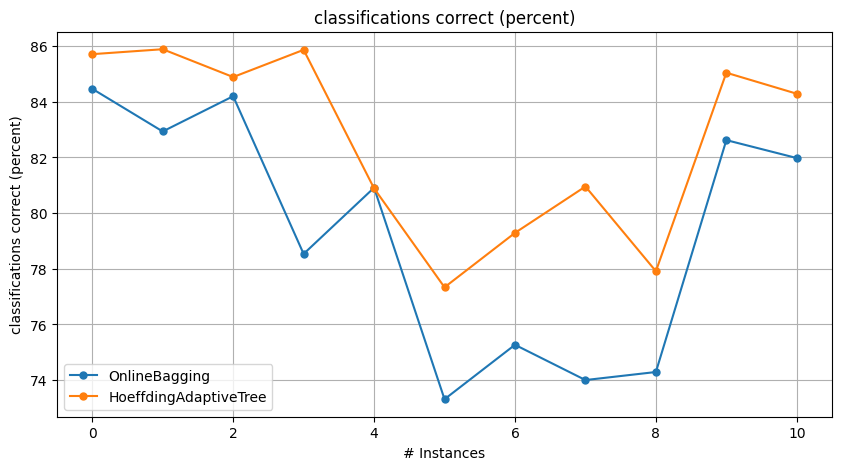

In [7]:
## What about comparing the results of both algorithms in a plot? 
from capymoa.evaluation.visualization import plot_windowed_results

plot_windowed_results(results_OB, results_HAT)

In [8]:
from moa.classifiers.meta import StreamingRandomPatches

elec_stream.restart()

srp = MOAClassifier(moa_learner=StreamingRandomPatches(), CLI="-s 10 -m 80")

results_srp = prequential_evaluation(stream=elec_stream, learner=srp, window_size=4500)

In [9]:
print(srp.CLI_help())

-l baseLearner (default: trees.HoeffdingTree -g 50 -c 0.01)
Classifier to train on instances.
-s ensembleSize (default: 100)
The number of models.
-o subspaceMode (default: Percentage (M * (m / 100)))
Defines how m, defined by mFeaturesPerTreeSize, is interpreted. M represents the total number of features.
-m subspaceSize (default: 60)
# attributes per subset for each classifier. Negative values = totalAttributes - #attributes
-t trainingMethod (default: Random Patches)
The training method to use: Random Patches, Random Subspaces or Bagging.
-a lambda (default: 6.0)
The lambda parameter for bagging.
-x driftDetectionMethod (default: ADWINChangeDetector -a 1.0E-5)
Change detector for drifts and its parameters
-p warningDetectionMethod (default: ADWINChangeDetector -a 1.0E-4)
Change detector for warnings (start training bkg learner)
-w disableWeightedVote
Should use weighted voting?
-u disableDriftDetection
Should use drift detection? If disabled, then the bkg learner is also disabled.
-

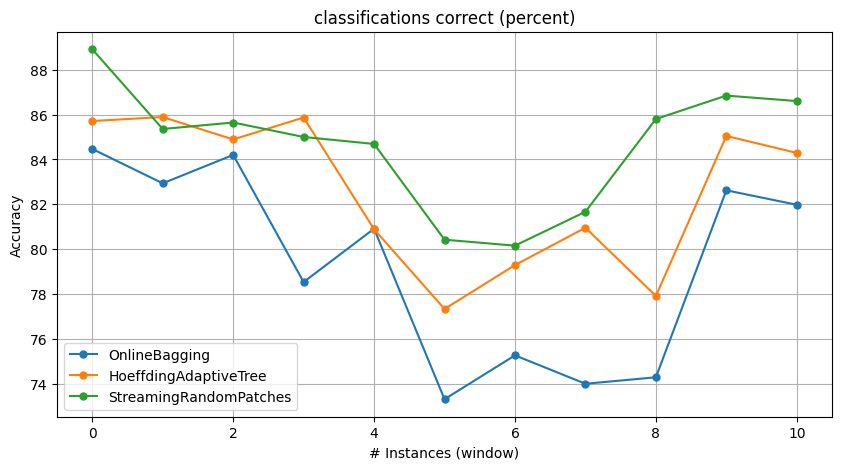

In [10]:
plot_windowed_results(results_OB, results_HAT, results_srp, xlabel="# Instances (window)", ylabel="Accuracy")

## Regression

In [11]:
## Open a regression dataset
from moa.classifiers.trees import FIMTDD
from moa.classifiers.meta import AdaptiveRandomForestRegressor
from capymoa.learner.learners import MOARegressor
from capymoa.learner.regressor.regressors import KNNRegressor


fried_stream = stream_from_file(path_to_csv_or_arff=DATA_PATH+"fried.arff")

# Create a learner
fimtdd = MOARegressor(schema=fried_stream.get_schema(), moa_learner=FIMTDD())
arfreg = MOARegressor(schema=fried_stream.get_schema(), moa_learner=AdaptiveRandomForestRegressor(), CLI="-s 10")
# There is a wrapper for KNNRegressor
knnreg = KNNRegressor(schema=fried_stream.get_schema(), k=3, window_size=1000)

results_fimtdd = prequential_evaluation(stream=fried_stream, learner=fimtdd, window_size=1000)
results_arfreg = prequential_evaluation(stream=fried_stream, learner=arfreg, window_size=1000)
results_knnreg = prequential_evaluation(stream=fried_stream, learner=knnreg, window_size=1000)

results_fimtdd['windowed'].metrics_per_window()

,classified instances,mean absolute error,root mean squared error,relative mean absolute error,relative root mean squared error,coefficient of determination,adjusted coefficient of determination
0,1000.0,5.674340,7.363274,1.394600,1.477190,-1.182092,-1.206386
1,1000.0,3.629025,4.549167,0.916570,0.934101,0.127455,0.117741
2,1000.0,3.045518,3.861026,0.759509,0.776583,0.396919,0.390204
3,1000.0,2.703028,3.405931,0.695283,0.713834,0.490442,0.484768
4,1000.0,2.436556,3.111116,0.599906,0.622877,0.612024,0.607705
5,1000.0,2.398800,3.035545,0.574334,0.592687,0.648722,0.644811
6,1000.0,2.212132,2.800096,0.547849,0.564145,0.681740,0.678197
7,1000.0,2.133315,2.751438,0.528914,0.552995,0.694196,0.690792
8,1000.0,2.107581,2.697964,0.494413,0.524178,0.725238,0.722179
9,1000.0,2.110955,2.638347,0.527524,0.529224,0.719922,0.716803


## Plotting Regression results

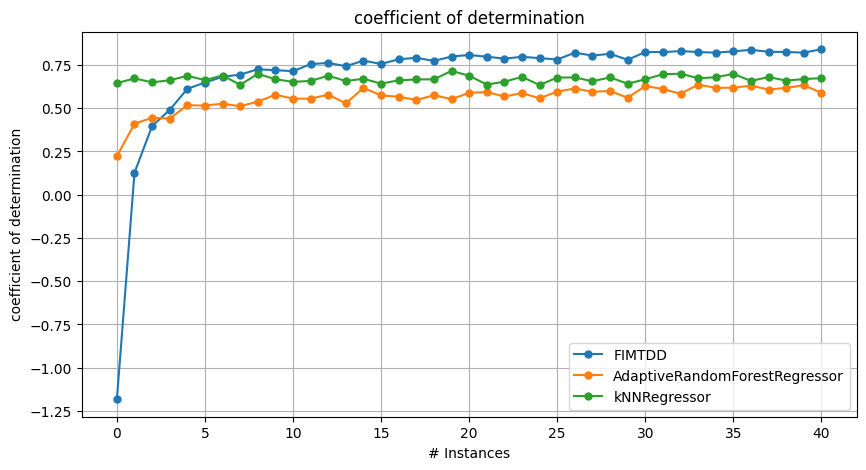

In [12]:
plot_windowed_results(results_fimtdd, results_arfreg, results_knnreg, metric="coefficient of determination")

## Plotting Drift Detection results (Classification)

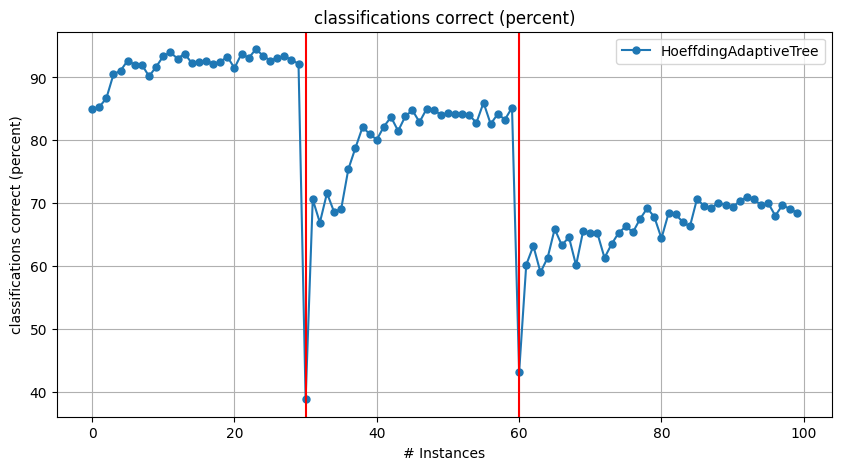

In [13]:
from moa.classifiers.trees import HoeffdingAdaptiveTree
from capymoa.learner.learners import MOAClassifier

hat = MOAClassifier(moa_learner=HoeffdingAdaptiveTree())

# Reading the stream from a file (it was generated earlier using MOA)
rtg2abrupt_stream = stream_from_file(path_to_csv_or_arff=DATA_PATH+"RTG_2abrupt.arff")

results_rtg_hat = prequential_evaluation(stream=rtg2abrupt_stream, learner=hat, window_size=1000)

plot_windowed_results(results_rtg_hat, drift_locations=[30,60]) #, gradual_drift_window_lengths=[10,10])

# Creating a synthetic stream with concept drifts from MOA

* Demonstrates the flexibility of the API, these level of manipulation of the API is expected from experienced MOA users. 

EvaluatePrequential -l trees.HoeffdingAdaptiveTree **-s (ConceptDriftStream -s generators.AgrawalGenerator -d (generators.AgrawalGenerator -f 2) -p 5000)** -e (WindowClassificationPerformanceEvaluator **-w 100**) **-i 10000 -f 100**


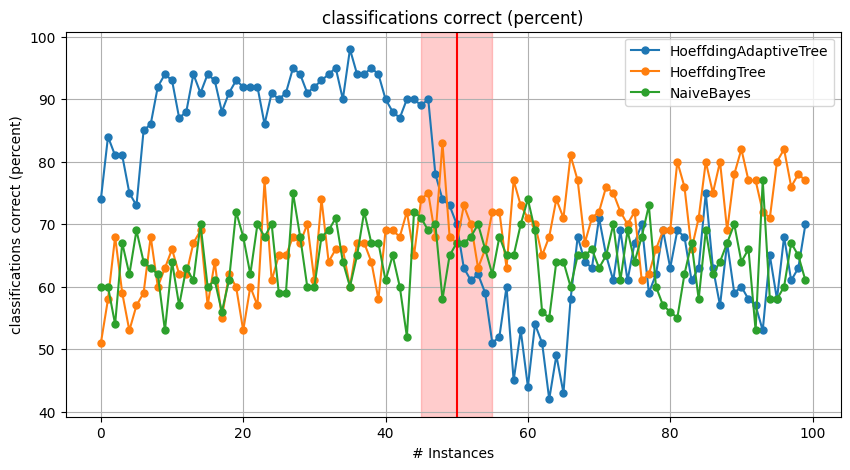

In [14]:
from capymoa.stream.stream import Stream
from moa.classifiers.trees import HoeffdingAdaptiveTree, HoeffdingTree
from moa.classifiers.bayes import NaiveBayes
from moa.streams import ConceptDriftStream

# Using the API to generate the data using the ConceptDriftStream and AgrawalGenerator.
# The drift location is based on the number of instances (5000) as well as the drift width (1000, the default value) 
stream_agr1drift = Stream(moa_stream=ConceptDriftStream(), 
                          CLI="-s generators.AgrawalGenerator -d (generators.AgrawalGenerator -f 2) -p 5000 -w 1000")


hat = MOAClassifier(moa_learner=HoeffdingAdaptiveTree())
ht = MOAClassifier(moa_learner=HoeffdingTree())
nb = MOAClassifier(moa_learner=NaiveBayes())

results_agr1drift_hat = prequential_evaluation(stream=stream_agr1drift, learner=hat, window_size=100, max_instances=10000)
results_agr1drift_ht = prequential_evaluation(stream=stream_agr1drift, learner=ht, window_size=100, max_instances=10000)
results_agr1drift_nb = prequential_evaluation(stream=stream_agr1drift, learner=nb, window_size=100, max_instances=10000)

# The drift location is based on the number of windows (50 i.e. 50x100) and the gradual_drift width as well (10 i.e. 10x100)
plot_windowed_results(results_agr1drift_hat,results_agr1drift_ht, results_agr1drift_nb, 
                      drift_locations=[50], 
                      gradual_drift_window_lengths=[10])

In [15]:
results_agr1drift_hat['windowed'].metrics_per_window()

,classified instances,classifications correct (percent),Kappa Statistic (percent),Kappa Temporal Statistic (percent),Kappa M Statistic (percent)
0,100.0,74.0,34.177215,39.534884,21.212121
1,200.0,84.0,58.137101,61.904762,48.387097
2,300.0,81.0,43.653618,51.282051,32.142857
3,400.0,81.0,52.970297,61.224490,45.714286
4,500.0,75.0,41.806331,56.140351,35.897436
...,...,...,...,...,...
95,9600.0,58.0,11.764706,8.695652,-5.000000
96,9700.0,68.0,30.675910,33.333333,15.789474
97,9800.0,61.0,15.875755,22.000000,-5.405405
98,9900.0,63.0,21.742809,15.909091,11.904762
